In [1]:
# Import libraries and settings
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import f1_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Run and see response data
Retail_Data_Response = pd.read_csv('Retail_Data_Response.csv')

mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')

# drop the columns that are not needed
mth_rolling_features.drop(columns=['Unnamed: 0'], inplace = True)
mth_day_counts.drop(columns=['Unnamed: 0'], inplace = True)
days_since_last_txn.drop(columns=['Unnamed: 0'], inplace = True)

monthly_features_outputs = mth_day_counts.merge(mth_rolling_features,how='left', on=['CLNT_NO','ME_DT'])
monthly_features_outputs = days_since_last_txn.merge(monthly_features_outputs,how='left', on=['CLNT_NO','ME_DT'])
# we want to merge by customer id, first change column names the same
# monthly_features_outputs.rename(columns={'CLNT_NO': 'customer_id'}) 
monthly_features_outputs = Retail_Data_Response.merge(monthly_features_outputs.rename(columns={'CLNT_NO': 'customer_id'}), how='left', on=['customer_id'])
monthly_features_outputs

,customer_id,response,ME_DT,days_since_last_txn,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
0,CS1112,0,2011-05-31,-1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CS1112,0,2011-06-30,15,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CS1112,0,2011-07-31,46,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CS1112,0,2011-08-31,12,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CS1112,0,2011-09-30,42,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,0,2014-11-30,98,0,0,0,0,0,0,...,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0
323544,CS9000,0,2014-12-31,129,0,0,0,0,0,0,...,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0
323545,CS9000,0,2015-01-31,160,0,0,0,0,0,0,...,35.0,1.0,0.166667,1.0,81.0,6.750000,35.0,3.0,0.250000,1.0
323546,CS9000,0,2015-02-28,0,0,0,1,0,0,0,...,34.0,1.0,0.166667,1.0,115.0,9.583333,35.0,4.0,0.333333,1.0


In [3]:
X_monthly = monthly_features_outputs.drop(columns=['response','customer_id','ME_DT'])
y_monthly = monthly_features_outputs.response
X_monthly = X_monthly.fillna(0)
X_monthly

,days_since_last_txn,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,mth_txn_amt_sum,mth_txn_cnt,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
0,-1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,15,0,0,0,0,0,0,1,56,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,46,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,12,1,0,0,0,0,0,0,96,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,42,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,98,0,0,0,0,0,0,0,0,0,...,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0
323544,129,0,0,0,0,0,0,0,0,0,...,35.0,2.0,0.333333,1.0,97.0,8.083333,35.0,4.0,0.333333,1.0
323545,160,0,0,0,0,0,0,0,0,0,...,35.0,1.0,0.166667,1.0,81.0,6.750000,35.0,3.0,0.250000,1.0
323546,0,0,0,1,0,0,0,0,34,1,...,34.0,1.0,0.166667,1.0,115.0,9.583333,35.0,4.0,0.333333,1.0


### 1.1.1. Split the train/test sets with 9:1 ratio. This split should give you approximately 291k/32k samples in train/test set, respectively.


In [4]:
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
    X_monthly, y_monthly, test_size=1/10, random_state=1147)
print(X_train_monthly.shape[0])
print(X_test_monthly.shape[0])

291193
32355


### 1.1.2. Initialize and create a for loop in which you take N samples (e.g. 50), build a tree model with the N samples and evaluate the test set AUC. Repeat the sampling process 10 times and append the test set AUC. The following table shows the desired output:

In [5]:
estimator = DecisionTreeClassifier(criterion = 'gini',random_state=1147, max_depth = 5,min_samples_split=5)
y_train_monthly = pd.DataFrame(y_train_monthly)

In [6]:
X_train_monthly.iloc[[4,6,7],:]

,days_since_last_txn,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,mth_txn_amt_sum,mth_txn_cnt,...,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M
41268,-1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
135939,22,0,0,0,0,1,0,0,93,1,...,97.0,3.0,0.500000,1.0,727.0,60.583333,103.0,9.0,0.75,1.0
18955,56,0,0,0,0,0,0,0,0,0,...,85.0,1.0,0.166667,1.0,242.0,20.166667,157.0,3.0,0.25,2.0


In [7]:
random.sample(range(0, X_train_monthly.shape[0]), 3)

[162181, 138940, 48128]

In [8]:
def eva_test_AUC(N):
    test_AUC = []
    sample = []

    for step in range(10):
        sample.append(step+1)
        sam = random.sample(range(0, X_train_monthly.shape[0]), N)
        X_sam = X_train_monthly.iloc[sam,:]
        y_sam = y_train_monthly.iloc[sam,:]
        model_step = estimator.fit(X_sam, y_sam)
        ## calculate AUC ## 
        # Scores for test set
        scores_test = model_step.predict_proba(X_test_monthly)[:, 1]
        # ROC Calc Test set
        fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
        # AUC Calc
        auc_test = auc(fpr_test, tpr_test)
        # record AUC
        test_AUC.append(auc_test)
    return test_AUC,sample
    

In [9]:
test_auc, sam_num = eva_test_AUC(50)

In [10]:
out2 = pd.DataFrame(sam_num,columns=['sample #'])
out2['Test AUC'] = test_auc

out2.style.hide_index()

/var/folders/7z/6tf98rc93hs5zf3rfz6g5_zm0000gn/T/ipykernel_26853/2429339379.py:4: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  out2.style.hide_index()


sample #,Test AUC
1,0.498300
2,0.526647
3,0.524324
4,0.498730
5,0.502928
6,0.549898
7,0.504509
8,0.505846
9,0.492784
10,0.511406


In [11]:
print('mean of AUC:',np.mean(test_auc))
print('std of AUC:',np.std(test_auc))

mean of AUC: 0.5115372652235812
std of AUC: 0.0164627817556799


### 1.1.3 Repeat the procedure you performed in the previous step for different sample size N

In [12]:
sam_size = []
test_mean = []
test_std = []
for n in [100,300,500,800,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,32000,34000,36000,38000,40000,42000,44000,46000,48000,50000]:
    sam_size.append(n)
    test_auc, sam_num = eva_test_AUC(n)
    test_mean.append(np.mean(test_auc))
    test_std.append(np.std(test_auc))

### 1.1.4. Build a table

In [13]:
out3 = pd.DataFrame(sam_size,columns=['sample size N'])
out3['Test AUC mean'] = test_mean
out3['Test AUC standard deviation'] = test_std
out3.style.hide_index()

/var/folders/7z/6tf98rc93hs5zf3rfz6g5_zm0000gn/T/ipykernel_26853/1183972644.py:4: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  out3.style.hide_index()


sample size N,Test AUC mean,Test AUC standard deviation
100,0.504038,0.031261
300,0.536494,0.035154
500,0.533555,0.036154
800,0.557858,0.023525
1000,0.550203,0.022590
2000,0.571017,0.028581
3000,0.595231,0.009949
4000,0.593145,0.007400
5000,0.600039,0.013749
6000,0.607476,0.009979


### 1.1.5. Using the matplotlib function errorbar, plot the model performance captured in the test AUC mean and standard deviation as a function of the sample size.

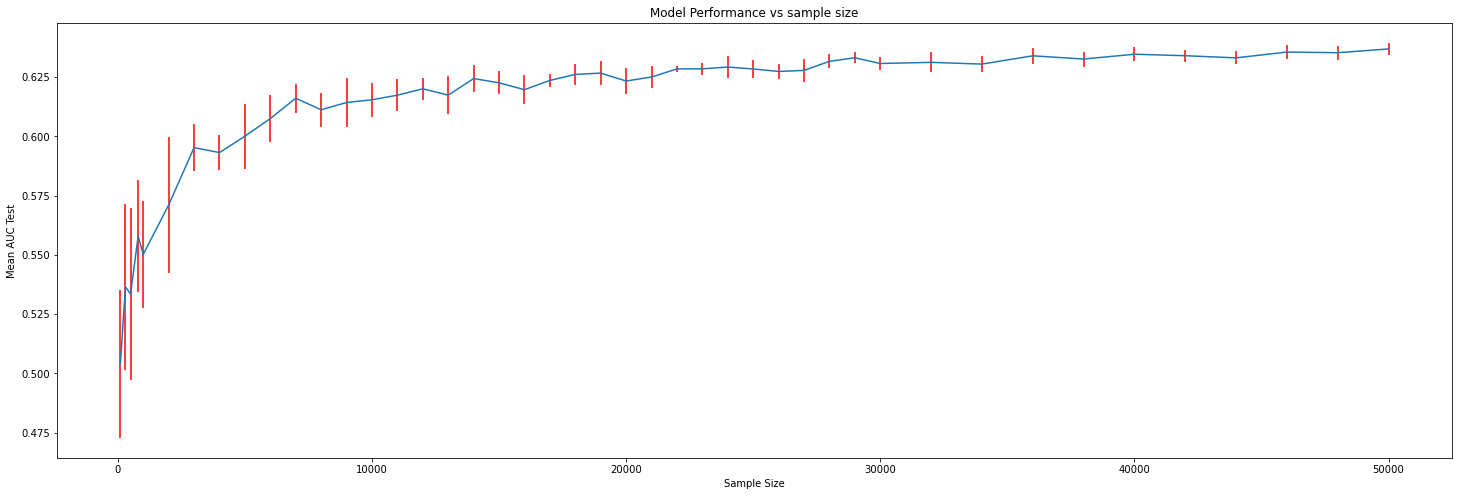

In [14]:
plt.figure(figsize=(25, 8))
plt.errorbar(sam_size, test_mean, yerr=test_std, ecolor = 'r') 
plt.title('Model Performance vs sample size')
plt.ylabel('Mean AUC Test')
plt.xlabel('Sample Size')
plt.show()

**From this plot, can you estimate what is the minimum number of samples needed to model the behaviour adequately?**

From the plot, we can see that curve of AUC tends to be flat and plain after sample size of 10000, and the error bar (standard deviation) gets very short after sample size of 20000. So I would say that minimum number of samples to mode the behaviour is 20000.